# Shortwave Fluxes
## Initial idea
Create box plots for all years of each month. E.g. All Jan for 2016-2025. The idea is to be able to ID where each set of outliers are and how we can remove them. 

In [1]:
# Imports
import intake
import matplotlib.pylab as plt
import numpy as np
from pvlib import clearsky
from pvlib.location import Location
import pandas as pd
import xarray as xr
from xhistogram.xarray import histogram

Load dataset.

In [2]:
# Load data, print variables for reference
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")
ds_rad = cat.BCO.radiation_c2_v1.to_dask()

time_shift = np.timedelta64(4, "h")

ds_rad["time"] = ds_rad.time.values - time_shift

print(f"{ds_rad}\n\n{ds_rad.data_vars}")

<xarray.Dataset> Size: 21GB
Dimensions:       (time: 297484717)
Coordinates:
    alt           float64 8B ...
    lat           float64 8B ...
    lon           float64 8B ...
  * time          (time) datetime64[ns] 2GB 2015-10-14T20:00:00 ... 2026-01-2...
Data variables: (12/16)
    LWD_diff      (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    LWD_diff_S    (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    LWD_diff_T    (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    LWD_diff_V    (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_diff      (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_diff_S    (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    ...            ...
    SWD_dir_T     (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_dir_V     (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_

# Commendere part of this for the RaC ARTS project

In [3]:
radiosonde_launch_times = [np.datetime64('2024-09-07T13:02:42.247016000'), np.datetime64('2024-09-10T12:48:09.237028992'), np.datetime64('2024-09-11T12:50:20.416996000'), np.datetime64('2024-09-12T09:47:48.752996992'), np.datetime64('2024-09-12T12:46:34.140000000'), np.datetime64('2024-09-13T12:49:12.500036992'), np.datetime64('2024-09-14T10:02:41.390100992'), np.datetime64('2024-09-16T09:49:37.697032000'), np.datetime64('2024-09-20T10:08:50.333015008'), np.datetime64('2024-09-20T12:49:07.789984992'), np.datetime64('2024-09-22T10:04:57.296972000')]
arts_surface_down_fluxes = [np.float64(1100.6535957560448), np.float64(1121.4590297333878), np.float64(1106.9364046701808), np.float64(943.4506435387189), np.float64(1115.3527528793977), np.float64(1111.2130625639793), np.float64(984.4253771272139), np.float64(950.9652177856314), np.float64(1012.2952000836304), np.float64(1122.6901354620595), np.float64(1002.276769249674)]

In [4]:
ds_rad_sel = ds_rad.sel(time=radiosonde_launch_times, method='nearest')

In [5]:
print(f"{ds_rad_sel.LWD_diff.values}\n\n{ds_rad_sel.SWD_global.values}")

[431.2  424.5  430.75 433.52 438.76 435.38 428.1  436.56 420.87 429.73
 416.61]

[ 945.48  985.93 1015.42  891.65 1090.54  343.04  885.27  210.75  891.04
  984.71 1022.11]


Initial downgoing shortwave radiation plot.

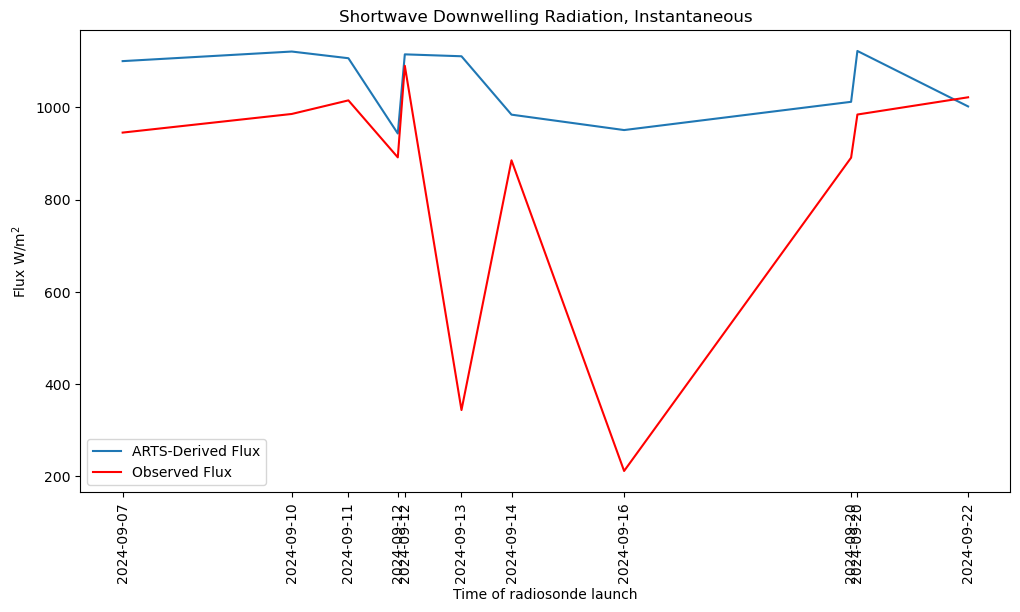

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(ds_rad_sel.time.values, arts_surface_down_fluxes, label="ARTS-Derived Flux")
plt.plot(ds_rad_sel.time.values, ds_rad_sel.SWD_global.values, label="Observed Flux", color='red')
plt.legend()
plt.xticks(ds_rad_sel.time.values, rotation="vertical")
plt.title("Shortwave Downwelling Radiation, Instantaneous")
plt.xlabel("Time of radiosonde launch")
plt.ylabel("Flux W/m$^2$")

plt.show()

A more beautiful plots.

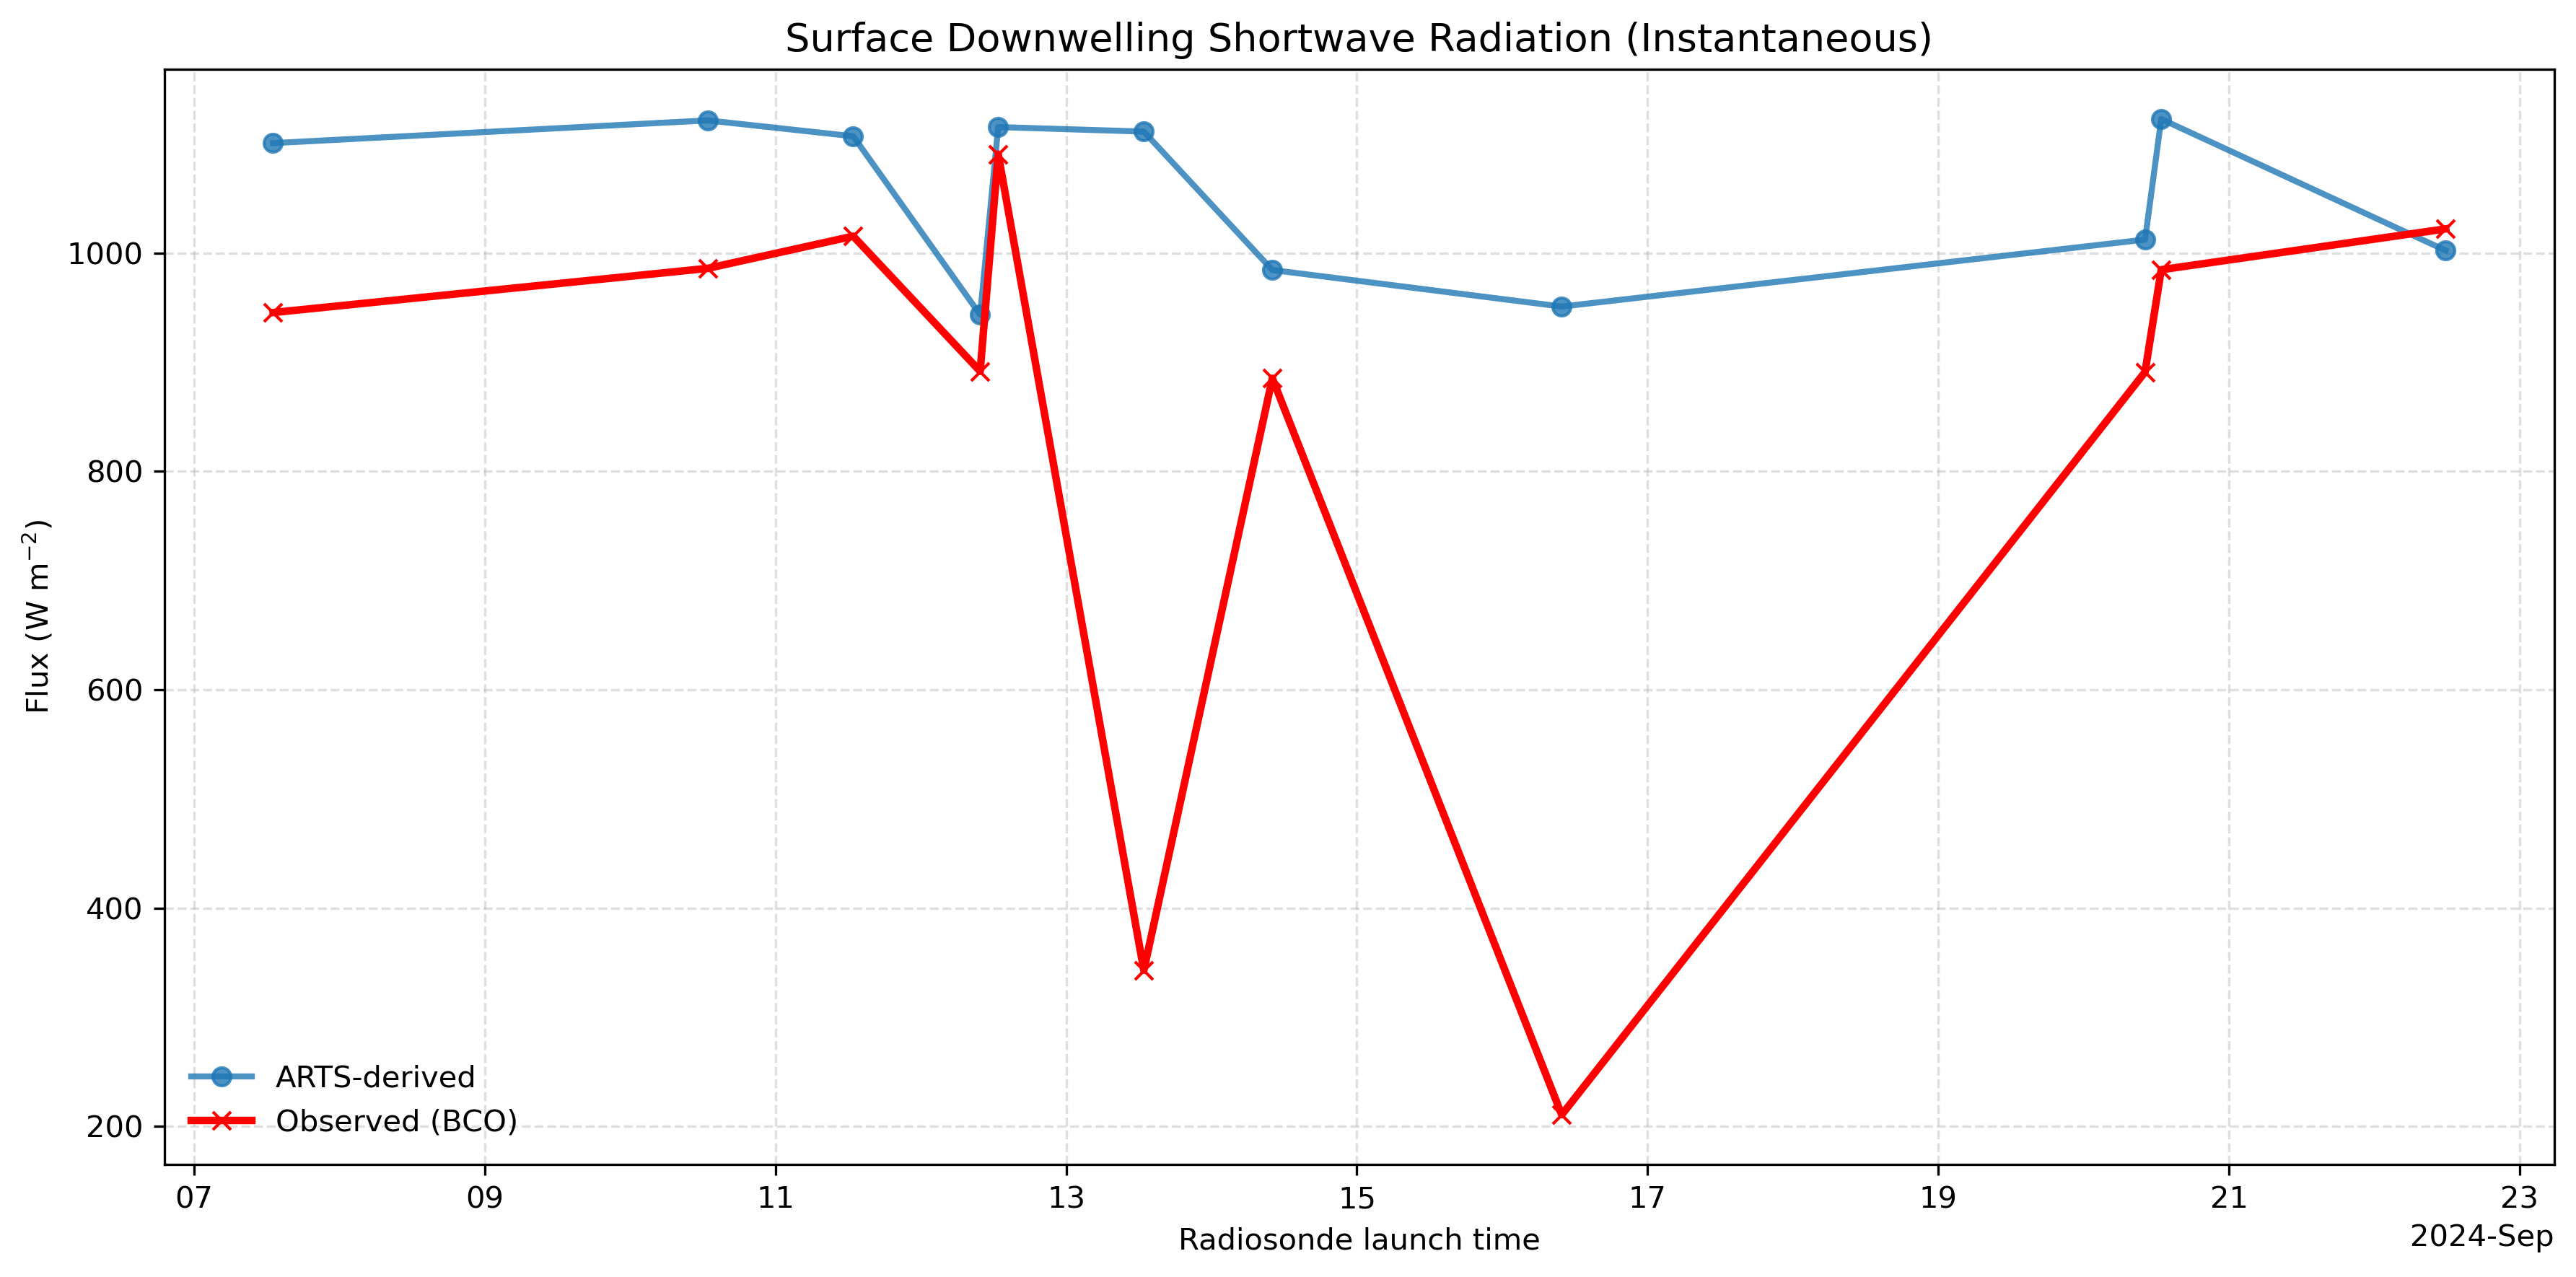

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.plot(
    ds_rad_sel.time,
    arts_surface_down_fluxes,
    label="ARTS-derived",
    linewidth=2,
    alpha=0.8,
    marker='o'
)

ax.plot(
    ds_rad_sel.time,
    ds_rad_sel.SWD_global,
    label="Observed (BCO)",
    linewidth=2.5,
    color="red",
    marker='x'
)

# Time-axis formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Labels and title
ax.set_title("Surface Downwelling Shortwave Radiation (Instantaneous)", fontsize=13)
ax.set_xlabel("Radiosonde launch time")
ax.set_ylabel(r"Flux (W m$^{-2}$)")

# Grid and legend
ax.grid(True, which="major", linestyle="--", alpha=0.4)
ax.legend(frameon=False)

fig.tight_layout()
plt.show()


There are a few outliers in the observed data. These can be seen by the anomalously low surface flux measurements on the 13th and 16th of November. These are likely due to the presence of clouds in the soundings.

At Barbados in September, instantaneous clear-sky shortwave downwelling radiation around local midday is typically well above 600 W m⁻². Values far below that during daytime are almost always cloud-affected.

The following script identifies then removes these soundings:

In [42]:
import numpy as np

obs  = np.asarray(ds_rad_sel.SWD_global.values)
mod  = np.asarray(arts_surface_down_fluxes)
time = np.asarray(ds_rad_sel.time.values)

mask_clear = obs >= 600.0

obs_f  = obs[mask_clear]
mod_f  = mod[mask_clear]
time_f = time[mask_clear]


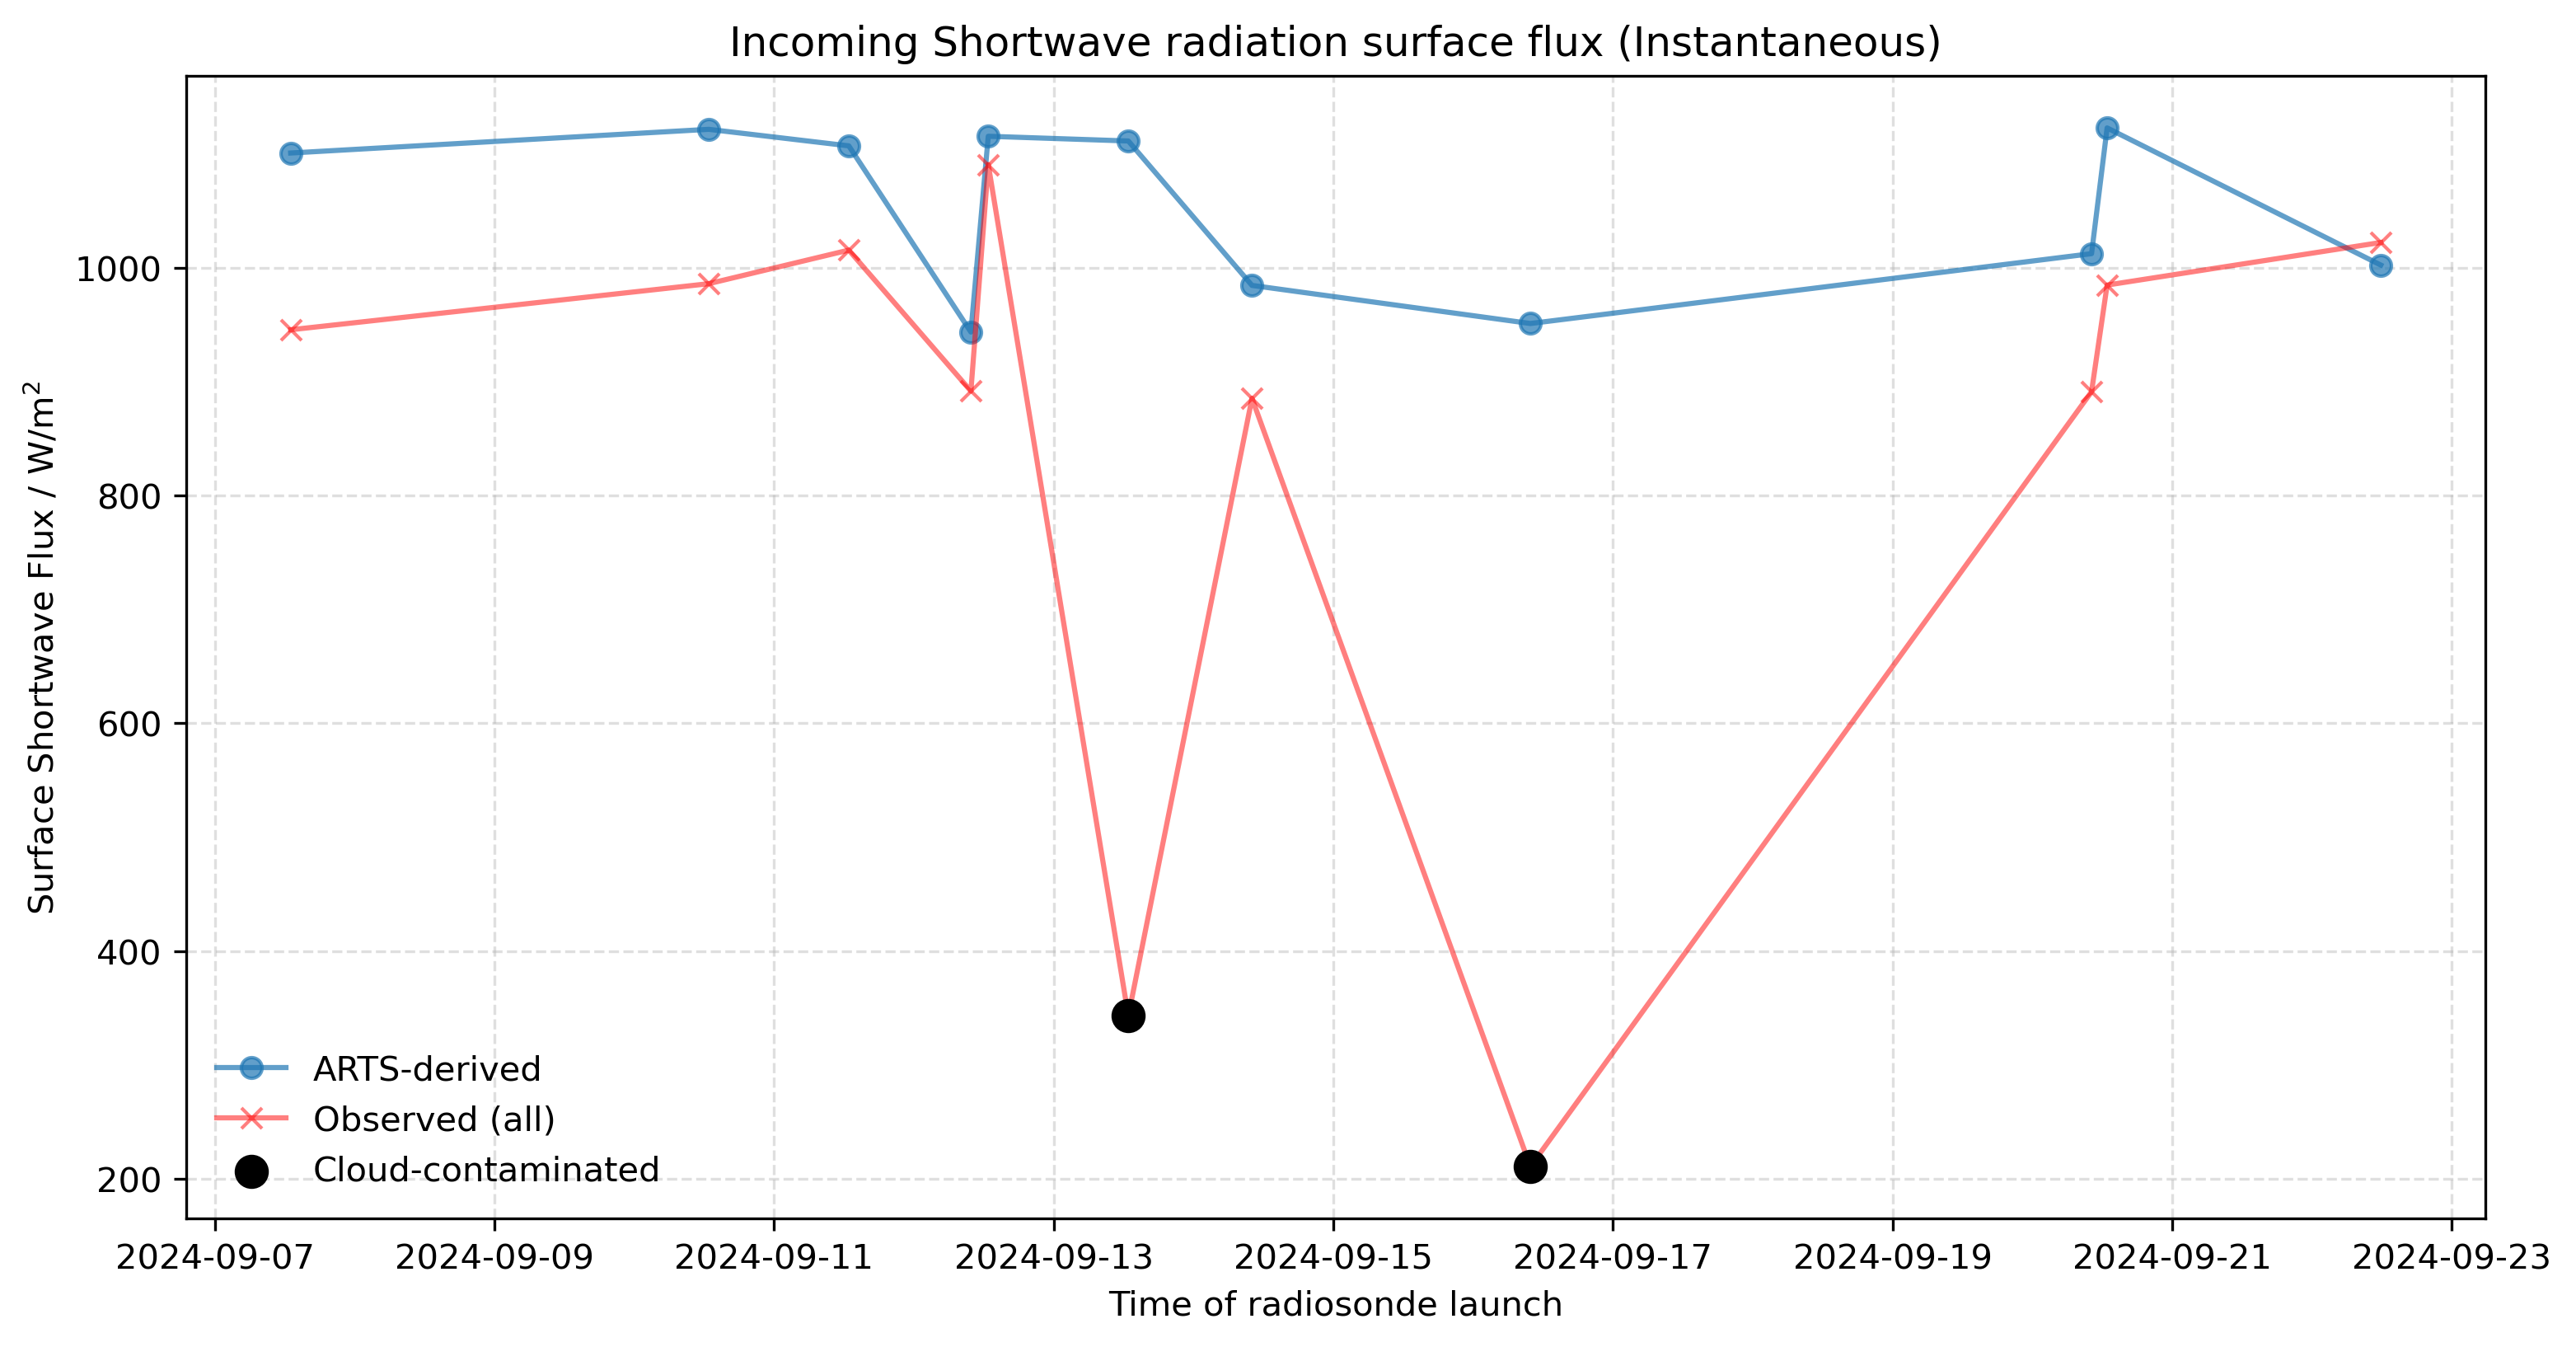

In [60]:

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.plot(time, mod, "o-", label="ARTS-derived", alpha=0.7)
ax.plot(time, obs, "x-", label="Observed (all)", color="red", alpha=0.5)

ax.set_title("Incoming Shortwave radiation surface flux (Instantaneous)")
ax.set_xlabel("Time of radiosonde launch")
ax.set_ylabel("Surface Shortwave Flux / W/m$^2$")

ax.scatter(
    time[~mask_clear],
    obs[~mask_clear],
    color="black",
    s=80,
    label="Cloud-contaminated",
    zorder=5
)

ax.legend(frameon=False)
ax.grid(True, linestyle="--", alpha=0.4)

plt.show()


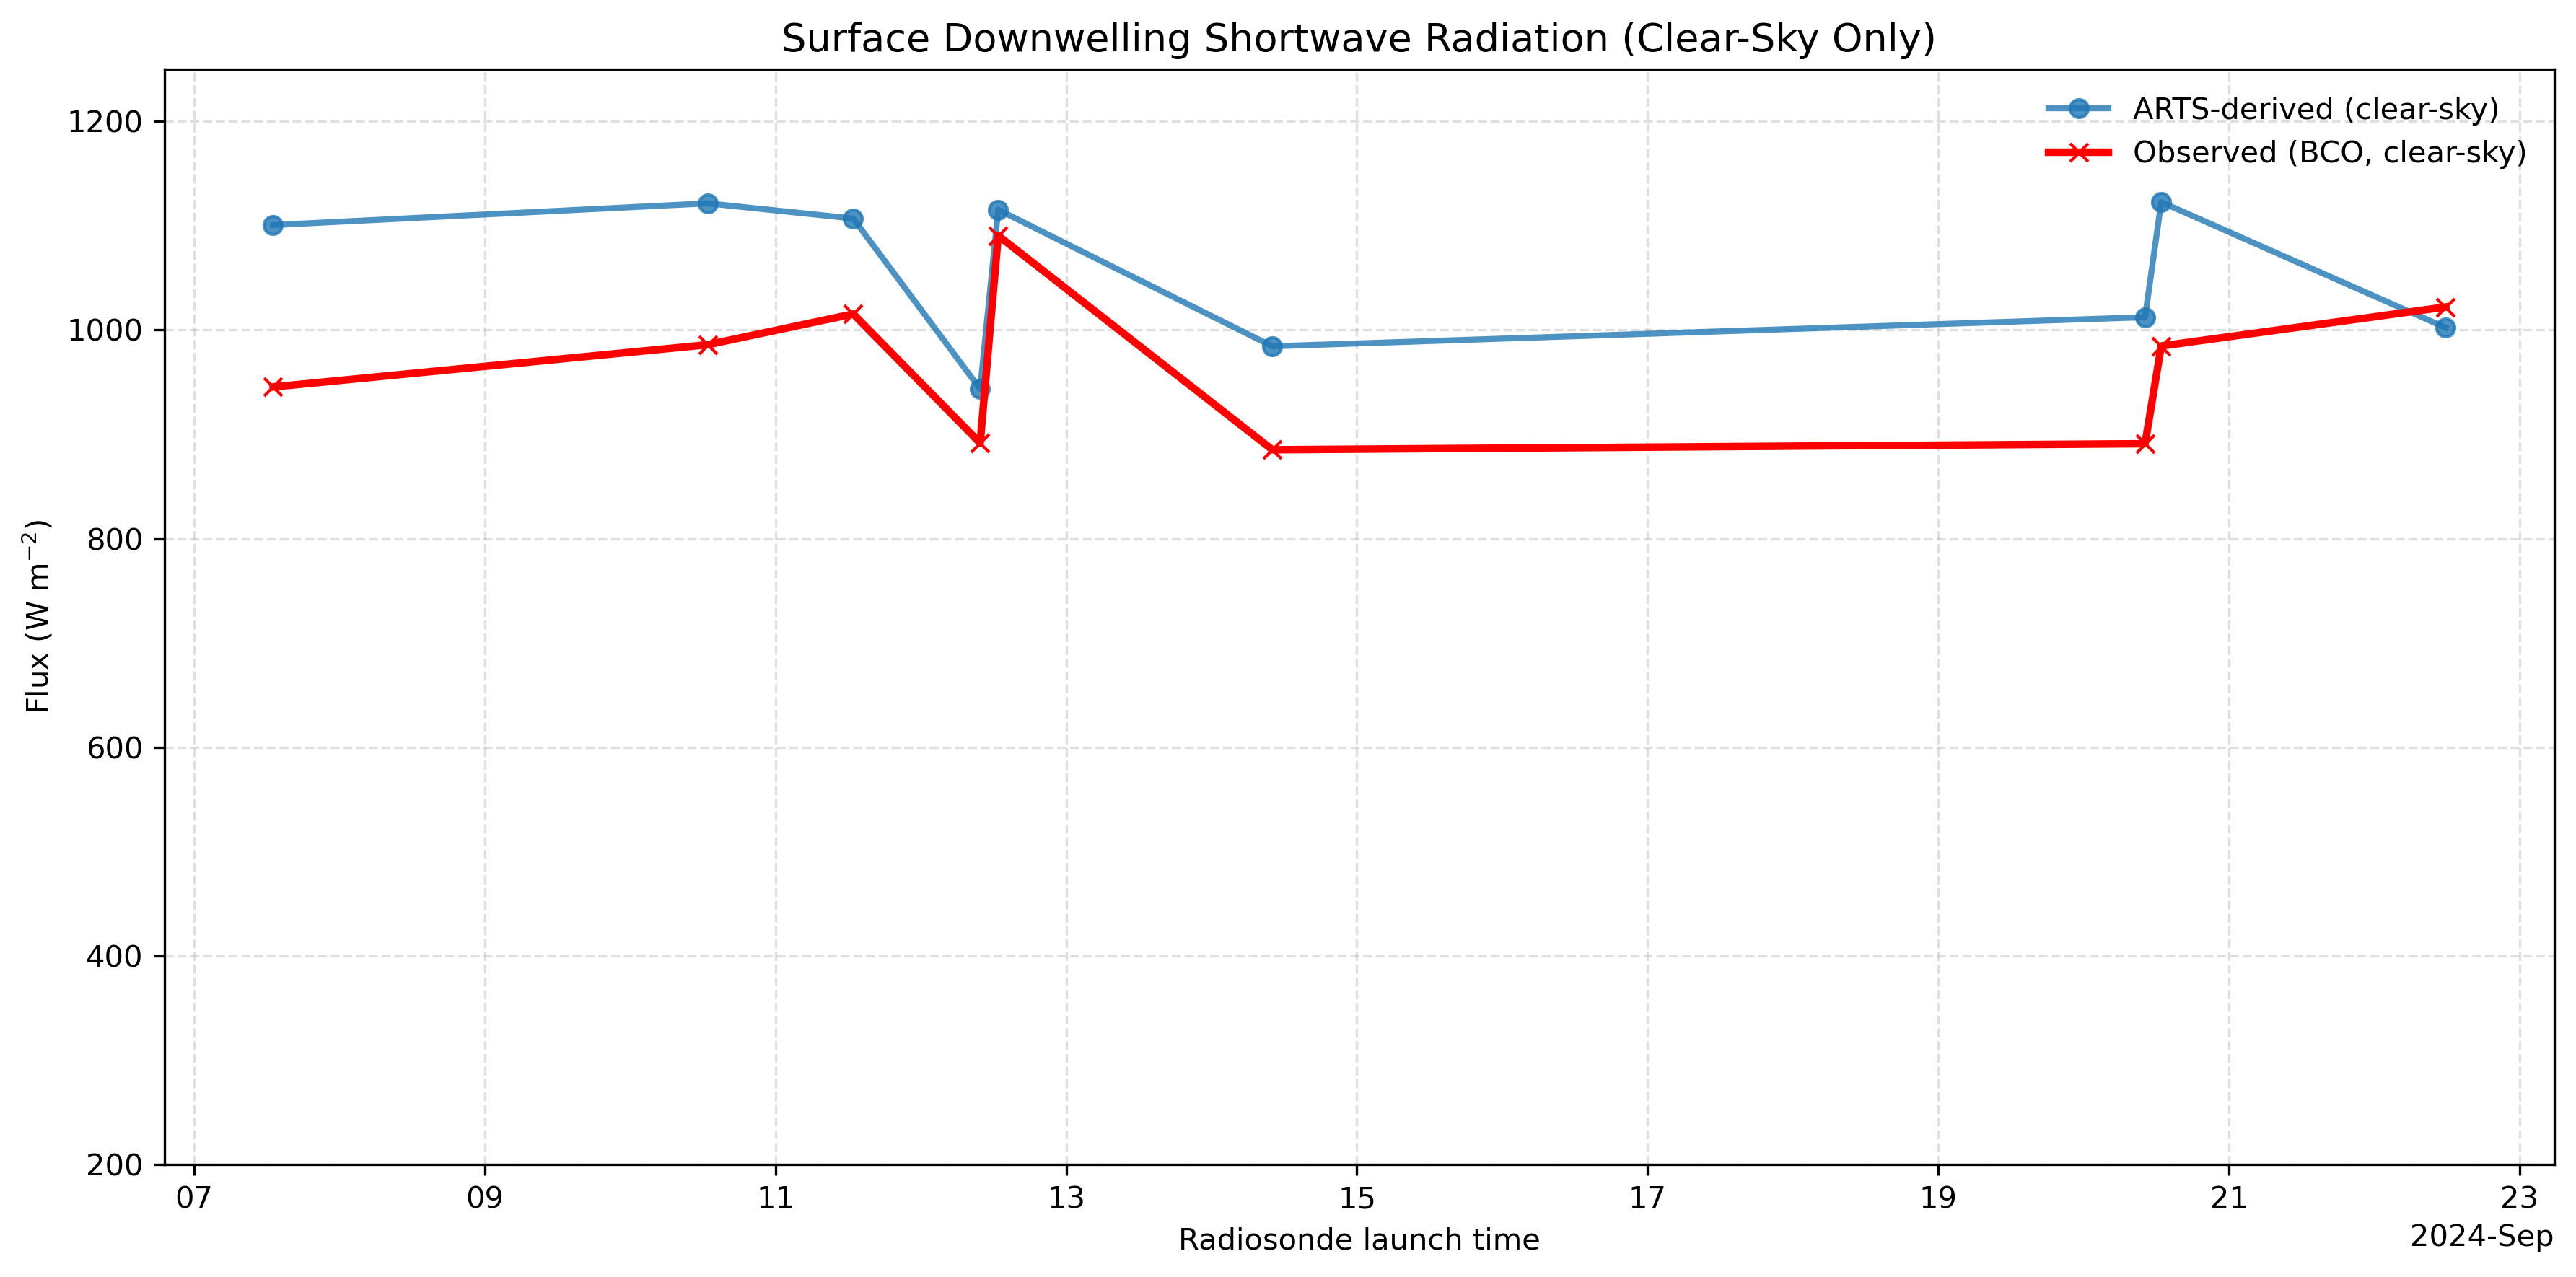

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.plot(
    time_f,
    mod_f,
    label="ARTS-derived (clear-sky)",
    linewidth=2,
    alpha=0.8,
    marker="o"
)

ax.plot(
    time_f,
    obs_f,
    label="Observed (BCO, clear-sky)",
    linewidth=2.5,
    color="red",
    marker="x"
)

# Time-axis formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())
)

# Labels and title
ax.set_title("Surface Downwelling Shortwave Radiation (Clear-Sky Only)", fontsize=13)
ax.set_xlabel("Radiosonde launch time")
ax.set_ylabel(r"Flux (W m$^{-2}$)")

ax.set_ylim(200, 1250)

# Grid and legend
ax.grid(True, which="major", linestyle="--", alpha=0.4)
ax.legend(frameon=False)

fig.tight_layout()
plt.show()


# Statistical Analysis
We now compute some statistics to gain some insights about the ARTs derived fluxes from the profiles versus the BCO.

1. **Systematic Bias or Mean bias error (MBE)** is defined as a measure of the tendency of a model to either underestimate or overestimate a value, with a desirable value of zero indicating no bias. A negative MBE indicates underestimation, while a positive MBE indicates overestimation. Source: [Mean Bias Error - an overview | ScienceDirect Topics](https://www.sciencedirect.com/topics/engineering/mean-bias-error)

$$\text{Systematic Mean Bias} = \dfrac{1}{n} \sum_{i=1}^n \mathrm{ARTS} - {\mathrm{OBS}}$$

2. **Variance Bias** is the systematic difference between the variance of model outputs and the variance of observations. $$\text{Variance Bias} = \text{Var(ARTS)} - \text{Var(Obs)}$$

    - **var_bias > 0**: The model has more variance than the observations.  
      It exaggerates fluctuations, making it appear too noisy.

    - **var_bias < 0**: The model has less variance than the observations.  
      It is too smooth and underestimates variability.

    - **var_bias ≈ 0**: Model variance matches observations well.

3. **Root Mean Square Error** is a measure of the differences between predicted values and observed values.  
It emphasizes larger errors because the differences are squared. $$\textbf{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} ( \text{ERA5}_i - \text{Obs}_i )^2 }$$

4. **Correlation Coefficient** measures the strength and direction of a linear relationship between two variables.

    $$\textbf{r} = \frac{\sum_{i=1}^{n} (o_i - \bar{o})(e_i - \bar{e})}{\sqrt{\left( \sum_{i=1}^{n} (o_i - \bar{o})^2 \right)\left( \sum_{i=1}^{n} (e_i - \bar{e})^2 \right)}}\quad\text{where } -1 \le r \le 1$$

    - $r = +1$: perfect positive linear relationship  
    - $r = -1$: perfect negative linear relationship
	- $r = 0$: no linear relationship (nonlinear relationships may still exist)

## Computation of Statistics

In [47]:
M = np.asarray(mod_f)
O = np.asarray(obs_f)

# Remove missing values (critical)
mask = np.isfinite(M) & np.isfinite(O)
M = M[mask]
O = O[mask]

# 1. Systematic Mean Bias
bias = np.mean(M - O)
print(f"Systematic Mean Bias: {bias:.2f} W/m²")

# 2. Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((M - O) ** 2))
print(f"RMSE: {rmse:.2f} W/m²")

# 3. Variance bias
var_bias = M.var() - O.var()
print(f"Variance Bias: {var_bias:.2f} (W/m²)²")

# 4. Correlation Coefficient
corr = np.corrcoef(M, O)[0, 1]
print(f"Correlation Coefficient: {corr:.3f}")

Systematic Mean Bias: 88.60 W/m²
RMSE: 104.40 W/m²
Variance Bias: -52.23 (W/m²)²
Correlation Coefficient: 0.654


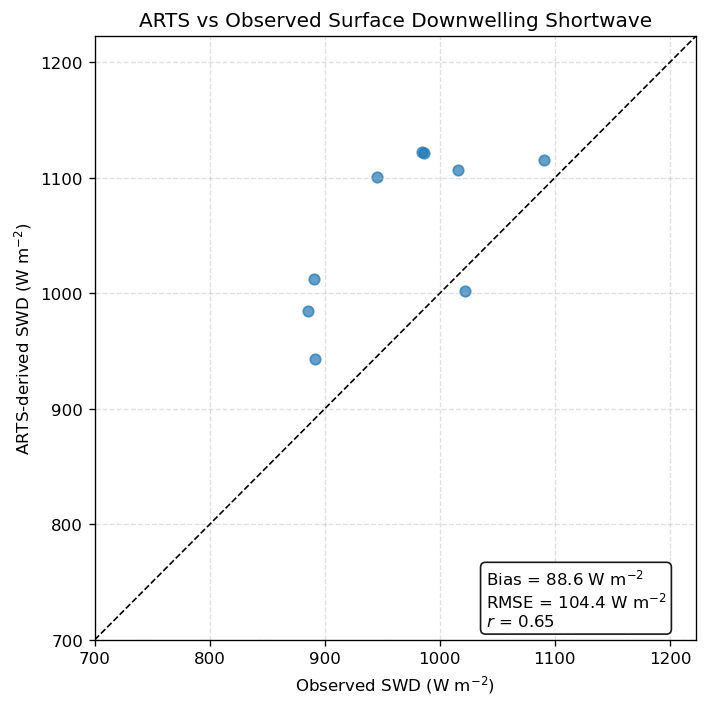

In [49]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)

ax.scatter(O, M, s=40, alpha=0.7)

lims = [
    min(700, M.min() + 100),
    max(700, M.max() + 100)
]
ax.plot(lims, lims, "k--", linewidth=1)

ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel(r"Observed SWD (W m$^{-2}$)")
ax.set_ylabel(r"ARTS-derived SWD (W m$^{-2}$)")
ax.set_title("ARTS vs Observed Surface Downwelling Shortwave")

textstr = (
    f"Bias = {bias:.1f} W m$^{{-2}}$\n"
    f"RMSE = {rmse:.1f} W m$^{{-2}}$\n"
    f"$r$ = {corr:.2f}"
)

ax.text(
    0.65, 0.12, textstr,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9)
)

ax.grid(True, linestyle="--", alpha=0.4)
fig.tight_layout()
plt.show()

# Longwave Fluxes

Here, we assume the dropsonde instantly traverses the depth of the atmosphere.

In [74]:
radiosonde_launch_times = [np.datetime64('2024-09-07T13:02:42.247016000'), np.datetime64('2024-09-10T12:48:09.237028992'), np.datetime64('2024-09-11T12:50:20.416996000'), np.datetime64('2024-09-12T09:47:48.752996992'), np.datetime64('2024-09-12T12:46:34.140000000'), np.datetime64('2024-09-13T12:49:12.500036992'), np.datetime64('2024-09-14T10:02:41.390100992'), np.datetime64('2024-09-16T09:49:37.697032000'), np.datetime64('2024-09-20T10:08:50.333015008'), np.datetime64('2024-09-20T12:49:07.789984992'), np.datetime64('2024-09-22T10:04:57.296972000')]

radiosonde_final_times = [np.datetime64('2024-09-07T18:34:36.998744992'), np.datetime64('2024-09-10T18:23:49.130379008'), np.datetime64('2024-09-11T18:17:11.998745984'), np.datetime64('2024-09-12T15:06:45.169448992'), np.datetime64('2024-09-12T18:53:28.167600000'), np.datetime64('2024-09-13T18:17:10.186276992'), np.datetime64('2024-09-14T15:59:27.146631008'), np.datetime64('2024-09-16T15:24:39.133641984'), np.datetime64('2024-09-20T15:54:05.101795008'), np.datetime64('2024-09-20T18:34:44.184224000'), np.datetime64('2024-09-22T15:29:06.007672000')]

down_sw = [np.float64(1100.6535957560448), np.float64(1121.4590297333878), np.float64(1106.9364046701808), np.float64(943.4506435387189), np.float64(1115.3527528793977), np.float64(1111.2130625639793), np.float64(984.4253771272139), np.float64(950.9652177856314), np.float64(1012.2952000836304), np.float64(1122.6901354620595), np.float64(1002.276769249674)]

olr = [np.float64(477.43819194057903), np.float64(476.98779282148877), np.float64(477.4627334500882), np.float64(477.60030728358254), np.float64(477.41025701861196), np.float64(477.5166378222125), np.float64(477.47740834805904), np.float64(477.54144867023314), np.float64(476.9191635626923), np.float64(477.3144265950498), np.float64(476.85934294817935)]

ds_rad_sel_inst = ds_rad.sel(time=radiosonde_launch_times, method='nearest')

time_index = list(range(0, len(radiosonde_final_times)))

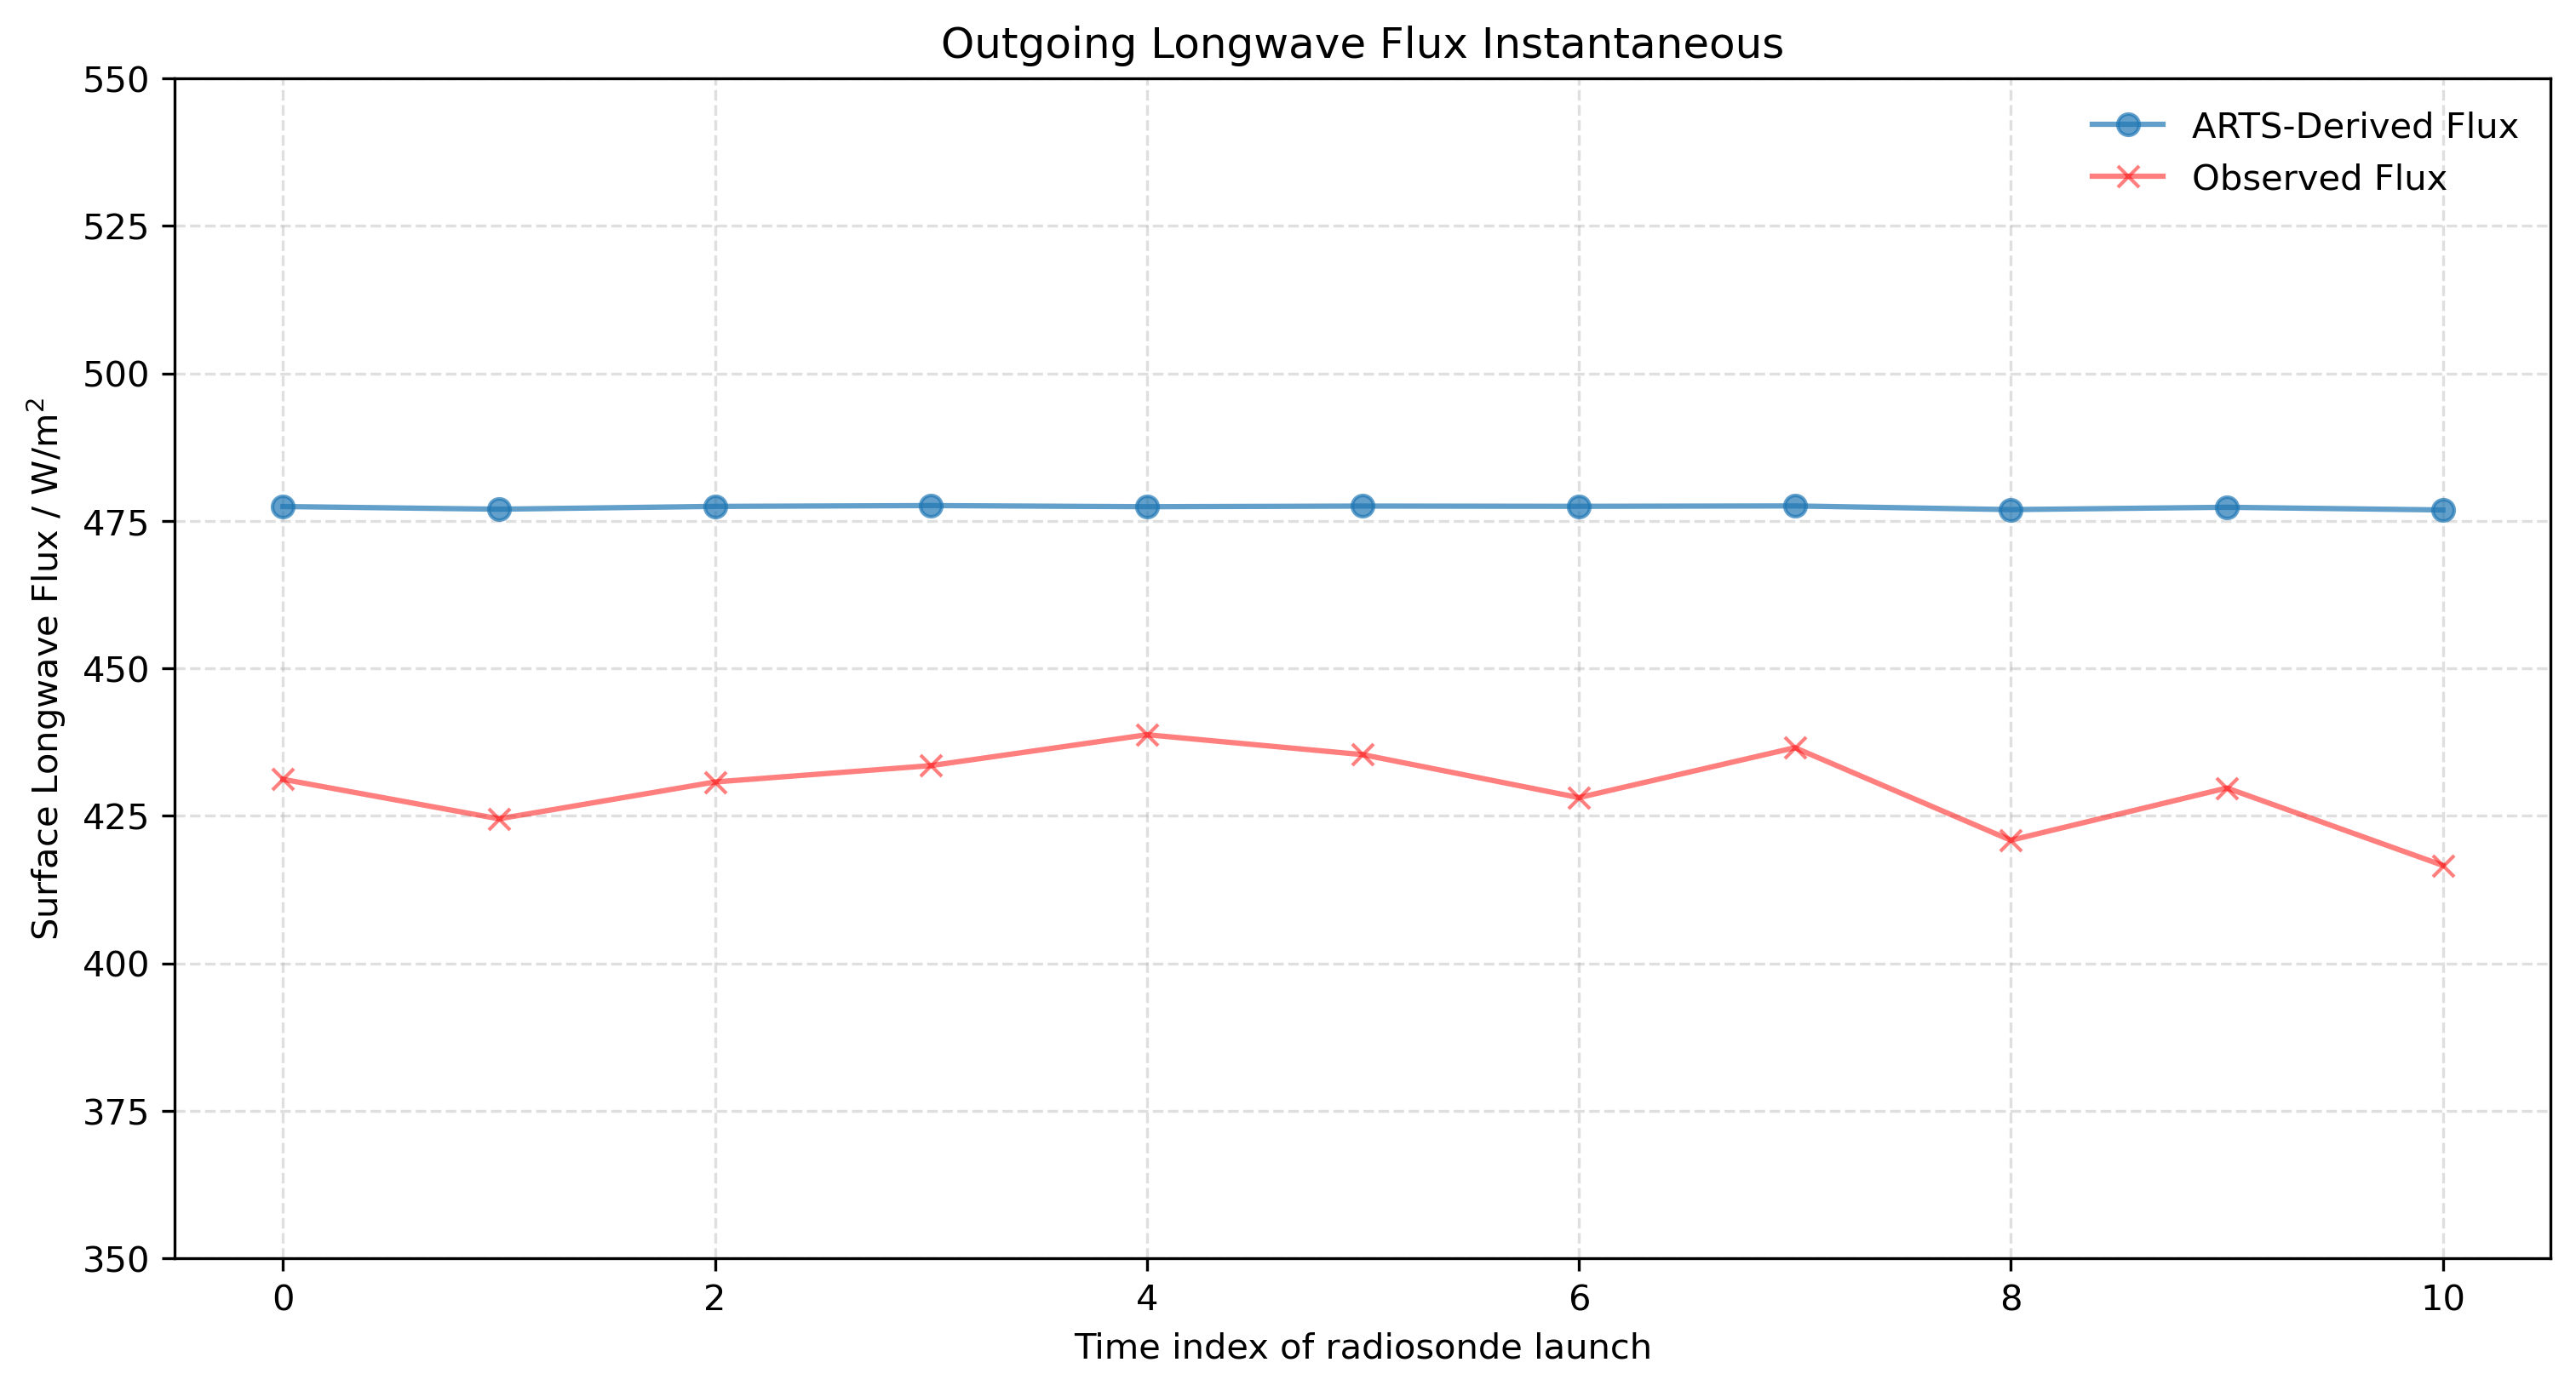

In [79]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.plot(time_index, olr, "o-", label="ARTS-Derived Flux", alpha=0.7)
ax.plot(time_index, ds_rad_sel_inst.LWD_diff.values, "x-", label="Observed Flux", color="red", alpha=0.5)

ax.set_title("Outgoing Longwave Flux Instantaneous")
ax.set_xlabel("Time index of radiosonde launch")
ax.set_ylabel("Surface Longwave Flux / W/m$^2$")
ax.set_ylim(350, 550)

ax.legend(frameon=False)
ax.grid(True, linestyle="--", alpha=0.4)

plt.show()


The ARTS derived surface fluxes seem to have an issue. This could stem from how the surface temperature was computed.

Systematic Mean Bias: 47.69 W/m²
RMSE: 48.09 W/m²
Variance Bias: 41.59 (W/m²)²
Correlation Coefficient: 0.877


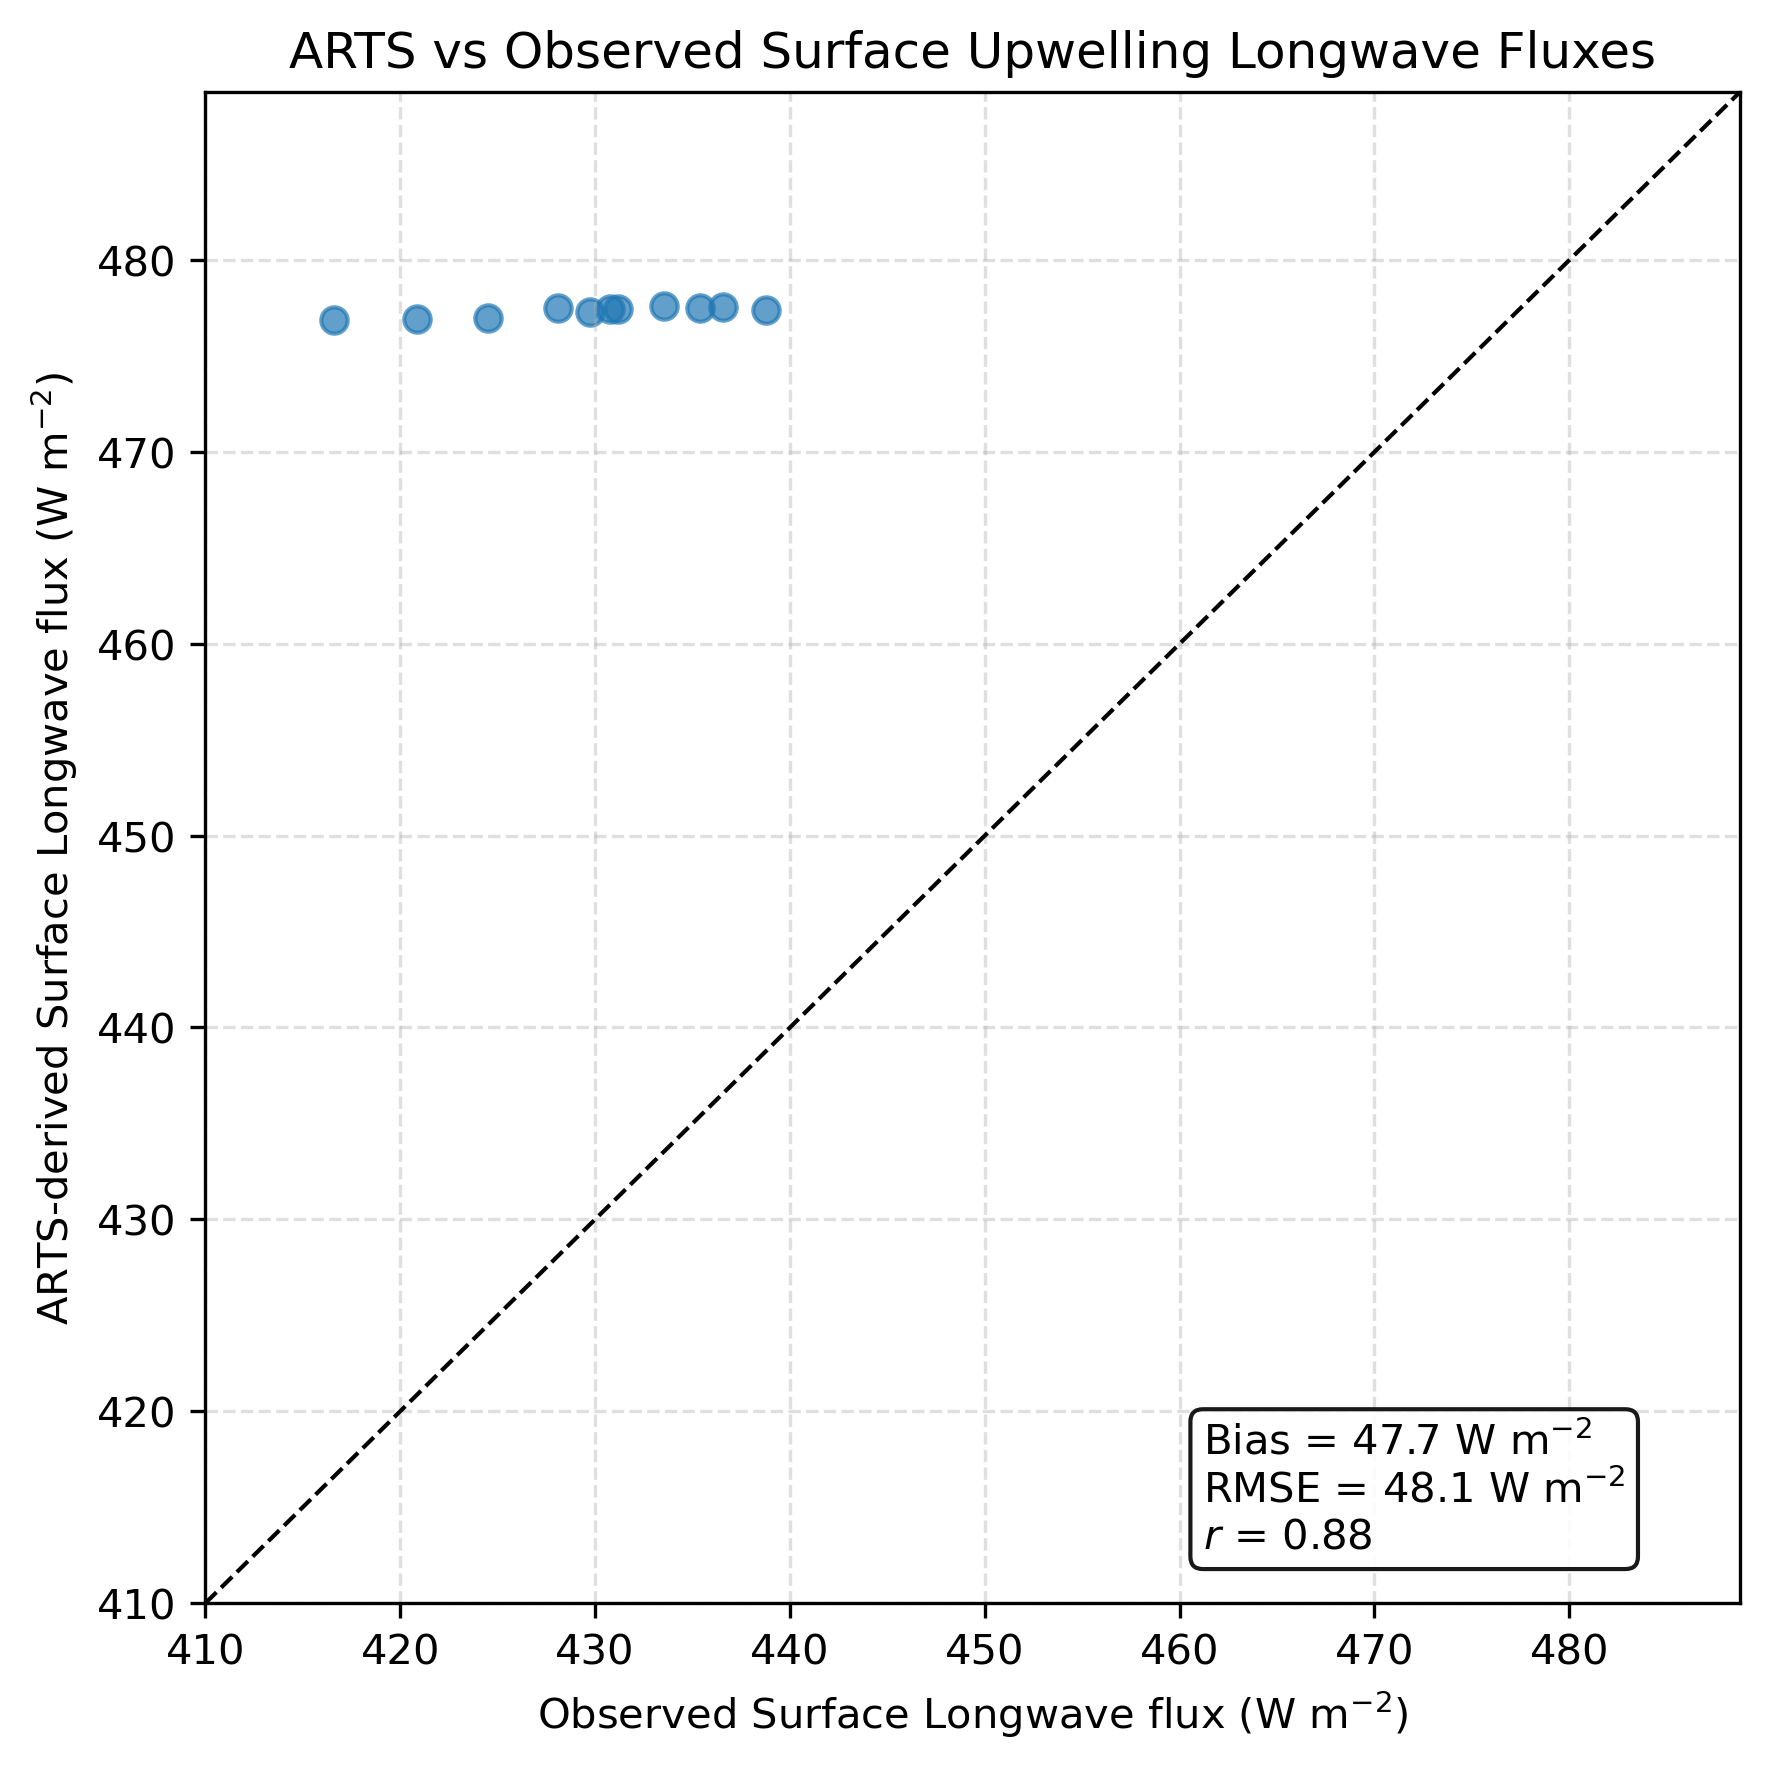

In [72]:
obs  = np.asarray(ds_rad_sel_inst.LWD_diff.values)
mod  = np.asarray(olr)
time = np.asarray(ds_rad_sel_inst.LWD_diff.values)

# 1. Systematic Mean Bias
bias = np.mean(mod - obs)
print(f"Systematic Mean Bias: {bias:.2f} W/m²")

# 2. Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((obs - mod) ** 2))
print(f"RMSE: {rmse:.2f} W/m²")

# 3. Variance bias
var_bias = obs.var() - mod.var()
print(f"Variance Bias: {var_bias:.2f} (W/m²)²")

# 4. Correlation Coefficient
corr = np.corrcoef(obs, mod)[0, 1]
print(f"Correlation Coefficient: {corr:.3f}")

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

ax.scatter(obs, mod, s=40, alpha=0.7)

lims = [
    min(410, obs.min() + 50),
    max(410, obs.max() + 50)
]
ax.plot(lims, lims, "k--", linewidth=1)

ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel(r"Observed Surface Longwave flux (W m$^{-2}$)")
ax.set_ylabel(r"ARTS-derived Surface Longwave flux (W m$^{-2}$)")
ax.set_title("ARTS vs Observed Surface Upwelling Longwave Fluxes")

textstr = (
    f"Bias = {bias:.1f} W m$^{{-2}}$\n"
    f"RMSE = {rmse:.1f} W m$^{{-2}}$\n"
    f"$r$ = {corr:.2f}"
)

ax.text(
    0.65, 0.12, textstr,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9)
)

ax.grid(True, linestyle="--", alpha=0.4)
fig.tight_layout()
plt.show()

Text(0, 0.5, 'Flux W/m$^2$')

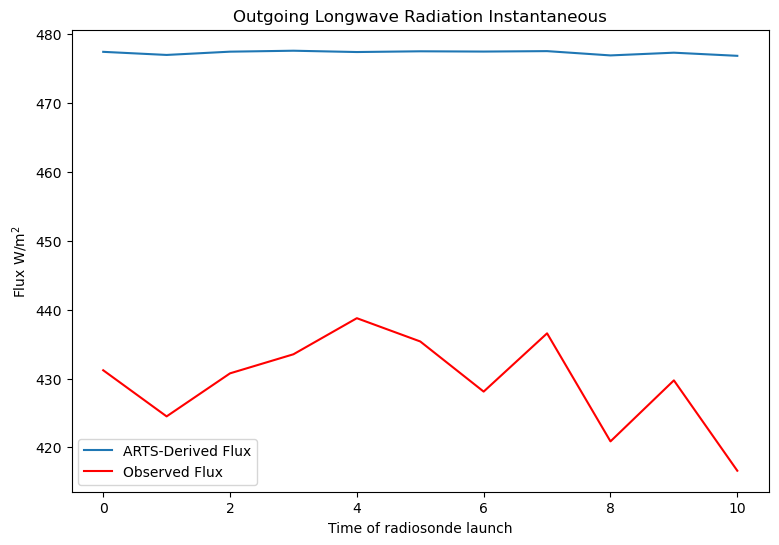

In [54]:
plt.figure(figsize=(9, 6))
plt.plot(time_index, olr, label="ARTS-Derived Flux")
plt.plot(time_index, ds_rad_sel_inst.LWD_diff.values, label="Observed Flux", color='red')
plt.legend()
# plt.xticks(ds_rad_sel.time.values, rotation="vertical")
plt.title("Outgoing Longwave Radiation Instantaneous")
plt.xlabel("Time of radiosonde launch")
plt.ylabel("Flux W/m$^2$")